# Global Texture Descriptor

### 分形维数 Fractal dimension (Hausdorff维数)
- 1维

In [107]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [108]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [109]:
def Fractal_Dimension(image_gray):
    # finding all the non-zero pixels
    pixels=[]
    for i in range(image_gray.shape[0]):
        for j in range(image_gray.shape[1]):
            if image_gray[i,j] > 0:
                pixels.append((i,j))

    Lx = image_gray.shape[1]
    Ly= image_gray.shape[0]
    # print(Lx, Ly)
    pixels = np.array(pixels)
    # print(pixels.shape)

    # computing the fractal dimension
    #considering only scales in a logarithmic list
    scales = np.logspace(0.01, 1, num=10, endpoint=False, base=2)
    Ns = []
    # looping over several scales
    for scale in scales:
        # print ("======= Scale :",scale)
        # computing the histogram
        H, edges = np.histogramdd(pixels, bins=(np.arange(0,Lx,scale),np.arange(0,Ly,scale)))
        Ns.append(np.sum(H>0))

    # linear fit, polynomial of degree 1
    coeffs = np.polyfit(np.log(scales), np.log(Ns), 1)

    # plt.plot(np.log(scales),np.log(Ns), 'o', mfc='none')
    # plt.plot(np.log(scales), np.polyval(coeffs,np.log(scales)))
    # plt.xlabel('log $\epsilon$')
    # plt.ylabel('log N')
    # plt.savefig('sierpinski_dimension.pdf')

    Hausdorff_D = -coeffs[0]
    # print ("The Hausdorff dimension is", Hausdorff_D) #the fractal dimension is the OPPOSITE of the fitting coefficient
    # np.savetxt("scaling.txt", list(zip(scales,Ns)))
    return Hausdorff_D

### 粒度 Coarseness
- 1维

In [110]:
def histogram_RGB(image):
    ar = image[:,:,0].flatten()
    ag = image[:,:,1].flatten()
    ab = image[:,:,2].flatten()

    histogram_r = np.histogram(ar, bins=255, density=True)
    histogram_g = np.histogram(ag, bins=255, density=True)
    histogram_b = np.histogram(ab, bins=255, density=True)

    return histogram_r, histogram_g, histogram_b

In [111]:
def Coarseness(image):
    histogram_r, histogram_g, histogram_b = histogram_RGB(image)
    Sm_r = np.mean(histogram_r[0])
    Sd_r = 0
    for i in range(0, 255):
        Sd_r += pow(histogram_r[0][i] - Sm_r, 2)

    Sm_g = np.mean(histogram_g[0])
    Sd_g = 0
    for i in range(0, 255):
        Sd_g += pow(histogram_g[0][i] - Sm_g, 2)

    Sm_b = np.mean(histogram_b[0])
    Sd_b = 0
    for i in range(0, 255):
        Sd_b += pow(histogram_b[0][i] - Sm_b, 2)

    Sd = Sd_r + Sd_g + Sd_b
    C = 1 - 1 / (1 + Sd)
    # print ("The Coarseness is", C)
    return C

### 熵 Entropy
- 1维

In [112]:
def Entropy(image):
    histogram_r, histogram_g, histogram_b = histogram_RGB(image)
    Se_r = 0
    for i in range(0, 255):
        Se_r += histogram_r[0][i] * math.log(histogram_r[0][i] + 0.00001, 2)
    # print(Se_r)
    Se_g = 0
    for i in range(0, 255):
        Se_g += histogram_g[0][i] * math.log(histogram_g[0][i] + 0.00001, 2)

    Se_b = 0
    for i in range(0, 255):
        Se_b += histogram_b[0][i] * math.log(histogram_b[0][i] + 0.00001, 2)

    Se = -(Se_r + Se_g + Se_b)
    # print ("The Entropy is", Se)
    return Se

### 空间灰度差统计 spatial gray-level difference statistics
- 维数与图像有关（相同）

In [113]:
def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm

def fast_glcm_mean(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm mean
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    mean = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            mean += glcm[i,j] * i / (nbit)**2

    return mean
#
# def fast_glcm_std(img, vmin=0, vmax=255, nbit=8, ks=5):
#     '''
#     calc glcm std
#     '''
#     h,w = img.shape
#     glcm = fast_glcm(img, vmin, vmax, nbit, ks)
#     mean = np.zeros((h,w), dtype=np.float32)
#     for i in range(nbit):
#         for j in range(nbit):
#             mean += glcm[i,j] * i / (nbit)**2
#
#     std2 = np.zeros((h,w), dtype=np.float32)
#     for i in range(nbit):
#         for j in range(nbit):
#             std2 += (glcm[i,j] * i - mean)**2
#
#     std = np.sqrt(std2)
#     return std
#
# def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
#     '''
#     calc glcm contrast
#     '''
#     h,w = img.shape
#     glcm = fast_glcm(img, vmin, vmax, nbit, ks)
#     cont = np.zeros((h,w), dtype=np.float32)
#     for i in range(nbit):
#         for j in range(nbit):
#             cont += glcm[i,j] * (i-j)**2
#
#     return cont
#
# def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
#     '''
#     calc glcm dissimilarity
#     '''
#     h,w = img.shape
#     glcm = fast_glcm(img, vmin, vmax, nbit, ks)
#     diss = np.zeros((h,w), dtype=np.float32)
#     for i in range(nbit):
#         for j in range(nbit):
#             diss += glcm[i,j] * np.abs(i-j)
#
#     return diss
#
# def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
#     '''
#     calc glcm homogeneity
#     '''
#     h,w = img.shape
#     glcm = fast_glcm(img, vmin, vmax, nbit, ks)
#     homo = np.zeros((h,w), dtype=np.float32)
#     for i in range(nbit):
#         for j in range(nbit):
#             homo += glcm[i,j] / (1.+(i-j)**2)
#
#     return homo
#
# def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
#     '''
#     calc glcm asm, energy
#     '''
#     h,w = img.shape
#     glcm = fast_glcm(img, vmin, vmax, nbit, ks)
#     asm = np.zeros((h,w), dtype=np.float32)
#     for i in range(nbit):
#         for j in range(nbit):
#             asm  += glcm[i,j]**2
#
#     ene = np.sqrt(asm)
#     return asm, ene
#
# def fast_glcm_max(img, vmin=0, vmax=255, nbit=8, ks=5):
#     '''
#     calc glcm max
#     '''
#     glcm = fast_glcm(img, vmin, vmax, nbit, ks)
#     max_  = np.max(glcm, axis=(0,1))
#     return max_
#
# def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
#     '''
#     calc glcm entropy
#     '''
#     glcm = fast_glcm(img, vmin, vmax, nbit, ks)
#     pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
#     ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
#     return ent

### Feature

In [114]:
def Feature(image):
    image_gray = rgb2gray(image)
    Hausdorff_D = Fractal_Dimension(image_gray)
    C = Coarseness(image)
    Se = Entropy(image)
    glcm_mean = fast_glcm_mean(image_gray)
    feature = [Hausdorff_D, C, Se, glcm_mean]
    return feature

### Feature LOSS

In [115]:
def cosine_similarity(x,y):
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom

def feature_Loss(feature1, feature2):
    loss = 0
    for i in range(3):
        # print("feature1[", i, "]: ", feature1[i])
        # print("feature2[", i, "]: ", feature2[i])
        loss += abs(feature1[i] - feature2[i])
        # print("loss: ", loss.shape)
    # print("loss without cosine_similarity: ", loss)
    # print("cosine_similarity: ", np.mean(cosine_similarity(feature1[3], feature2[3])))
    loss += np.mean(cosine_similarity(feature1[3], feature2[3]))
    # print("loss: ", loss)
    return loss

In [116]:
image1 = cv2.imread("./dataset1/PANCREAS_0004.png")
image1_2 = cv2.imread("./dataset1/PANCREAS_0005.png")
image2 = cv2.imread("./dataset2/img_0000.png")

feature1 = Feature(image1)
feature1_2 = Feature(image1_2)
feature2 = Feature(image2)
Loss1 = feature_Loss(feature1, feature2)
Loss2 = feature_Loss(feature1, feature1_2)

print("Loss1 2 is", Loss1)
print("Loss1 1_2 is", Loss2)

Loss1 2 is 17.813051565650955
Loss1 1_2 is 4.784506308262554


In [117]:
image1_gray = rgb2gray(image1)
image1_2_gray = rgb2gray(image1_2)
# plt.imshow(image1)
# plt.show()
# plt.imshow(image1_gray, cmap="gray")
# plt.show()
# plt.imshow(image1_2)
# plt.show()
# plt.imshow(image1_2_gray, cmap="gray")
# plt.show()

In [118]:
def read_directory(directory_name):
    array_of_img = []
    for filename in os.listdir(r"./"+directory_name):
        # print(filename) #just for test
        # #img is used to store the image data
        img = cv2.imread(directory_name + "/" + filename)
        img_gray = rgb2gray(img)
        array_of_img.append(img_gray)
    return array_of_img

dataset1 = read_directory("dataset1")
dataset2 = read_directory("dataset2")
print(len(dataset1), len(dataset2))

5 5


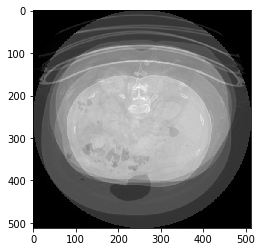

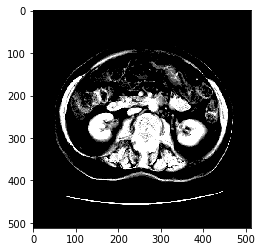

True

In [119]:
row = image1_gray.shape[0]
col = image1_gray.shape[1]

coalesce_img_1 = np.zeros(image1_gray.shape)
coalesce_img_2 = np.zeros(image1_gray.shape)
for i in range(row):
    for j in range(col):
        # coalesce_img[i][j] = (image1_gray[i][j] + image1_2_gray[i][j]) / 2
        for img in dataset1:
            coalesce_img_1[i][j] += img[i][j]
        coalesce_img_1[i][j] /= len(dataset1)
        for img in dataset2:
            coalesce_img_2[i][j] += img[i][j]
        coalesce_img_2[i][j] /= len(dataset2)

plt.imshow(coalesce_img_1, cmap="gray")
plt.show()
plt.imshow(coalesce_img_2, cmap="gray")
plt.show()

cv2.imwrite('dataset1_coalesce.png', coalesce_img_1)
cv2.imwrite('dataset2_coalesce.png', coalesce_img_2)

In [120]:
image1 = cv2.imread("./dataset1/PANCREAS_0004.png")
image2 = cv2.imread("./dataset2/img_0000.png")

dataset1_coalesce = cv2.imread("./dataset1_coalesce.png")
dataset2_coalesce = cv2.imread("./dataset2_coalesce.png")

# print(image1.shape)
# print(dataset1_coalesce.shape)

feature1 = Feature(image1)
feature2 = Feature(image2)

dataset_feature1 = Feature(dataset1_coalesce)
dataset_feature2 = Feature(dataset2_coalesce)

# print(dataset_feature1[0])
# print(feature1[3].shape)
# print(dataset_feature1[3].shape)
# print(np.mean(cosine_similarity(feature1[3], dataset_feature1[3])))

Loss1_1 = feature_Loss(feature1, dataset_feature1)
Loss1_2 = feature_Loss(feature1, dataset_feature2)

Loss2_1 = feature_Loss(feature2, dataset_feature1)
Loss2_2 = feature_Loss(feature2, dataset_feature2)

print("Loss1_1 is", Loss1_1)
print("Loss1_2 is", Loss1_2)

print("Loss2_1 is", Loss2_1)
print("Loss2_2 is", Loss2_2)

Loss1_1 is 6.105845547842698
Loss1_2 is 15.138130260134345
Loss2_1 is 23.8168667051868
Loss2_2 is 2.6754685042117403
